<a href="https://colab.research.google.com/github/sherryzhou0201/machine-learning/blob/master/Churn_Supervised_Learning_Project_Sherry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# User Churn Prediction

This project uses supervised learning models to identify customers who are likely to stop using service in the future. Furthermore, we will analyze top factors that influence user retention.


<li> data informaton
https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers


Churn--subscribed before, but then the customers left.
Ideally , we want to predict the customers who are going to churn. Then we can send some coupons/deals ,try to keep these customers. 

## Contents

<ul>

<li>[Part 1: Data Exploration]
<ol style="list-style-type: lower-alpha; padding-bottom: 0;">
  <li style="margin-left:2em">Understand the raw data</li>
  <li style="margin-left:2em; padding-bottom: 0;">Understand the features</li>
</ol>
<li>[Part 2: Feature Preprocessing]
<ol style="list-style-type: lower-alpha; padding-bottom: 0;">
  <li style="margin-left:2em">Feature Encoding</li>
  <li style="margin-left:2em; padding-bottom: 0;">Feature Scaling</li>
</ol>
<li>[Part 3: Model Training and Results Evaluation]
<ol style="list-style-type: lower-alpha; padding-bottom: 0;">
  <li style="margin-left:2em">Splitting the data</li>
  <li style="margin-left:2em; padding-bottom: 0;">Model training and selection</li>
  <li style="margin-left:2em">Hyperparmeter tuning</li>
  <li style="margin-left:2em; padding-bottom: 0;">Model evaluation</li>
</ol>
<li>[Part 4: Feature Selection]
</ul>

# Part 0: Setup Google Drive Environment

<li> Google drive was set up following the steps :

https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92



In [1]:
# method 1 install pydrive to load data
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [2]:
link = 'https://drive.google.com/open?id=1R1Zt68U6aPw9OW9qWob2U41EX1YukG14'
fluff, id = link.split('=')
print(fluff)
print(id)
file=drive.CreateFile({'id':id})
file.GetContentFile('bank_churn.csv')

https://drive.google.com/open?id
1R1Zt68U6aPw9OW9qWob2U41EX1YukG14


# Part 1: Data Exploration


### Part 1.1: Understand the Raw Dataset

This data set only includes 1M records, which is relatively small. If the data are larger, I will suggest to use pyspark. However for this project, only pandas dataframe was used.

In this data, the output is Existed (Churn), and we want to build a model to see if we can predict cutomer's Churn behavior.

In [3]:
import pandas as pd

churn_df = pd.read_csv('bank_churn.csv')
churn_df.info() 
# it looks like there is no missing data , but I need to see the actuall data to make sure 
# 10000*14 data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
churn_df.head() 

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
# check the # of unique values for each column, have a brief idea if the data makes sense
churn_df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [6]:
# check the basic info about our output ('Exited'-churn) variable
churn_df.groupby(churn_df['Exited']).size() 
# it is a little bit disproportional, but. not very extreme. 
# However, since the prop to stay is almost 80% if we just assume every client get the answer 0
# we need to be carefull to pick the correct evaluation critera when we try to measure the performance of our model.

Exited
0    7963
1    2037
dtype: int64

### Part 1.2:  Understand the features

By looking at the raw data set above, I separate the possible features into two groups, continuous and cateogrial and check them separately to get a better data intuition of this features.

In [7]:
# understand the numerical features
churn_df[['CreditScore','Age','Tenure','NumOfProducts','Balance','EstimatedSalary']].describe()  

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,1.530200,76485.889288,100090.239881
std,96.653299,10.487806,2.892174,0.581654,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,1.000000,0.000000,11.580000
25%,584.000000,32.000000,3.000000,1.000000,0.000000,51002.110000
50%,652.000000,37.000000,5.000000,1.000000,97198.540000,100193.915000
75%,718.000000,44.000000,7.000000,2.000000,127644.240000,149388.247500
max,850.000000,92.000000,10.000000,4.000000,250898.090000,199992.480000


In [8]:
# check the feature distribution using plots
# do boxplot, countplot
import matplotlib.pyplot as plt # useful for subplots
import seaborn as sns 

Text(0.5, 0.98, 'Boxplots for numerical features for current/existed customers')

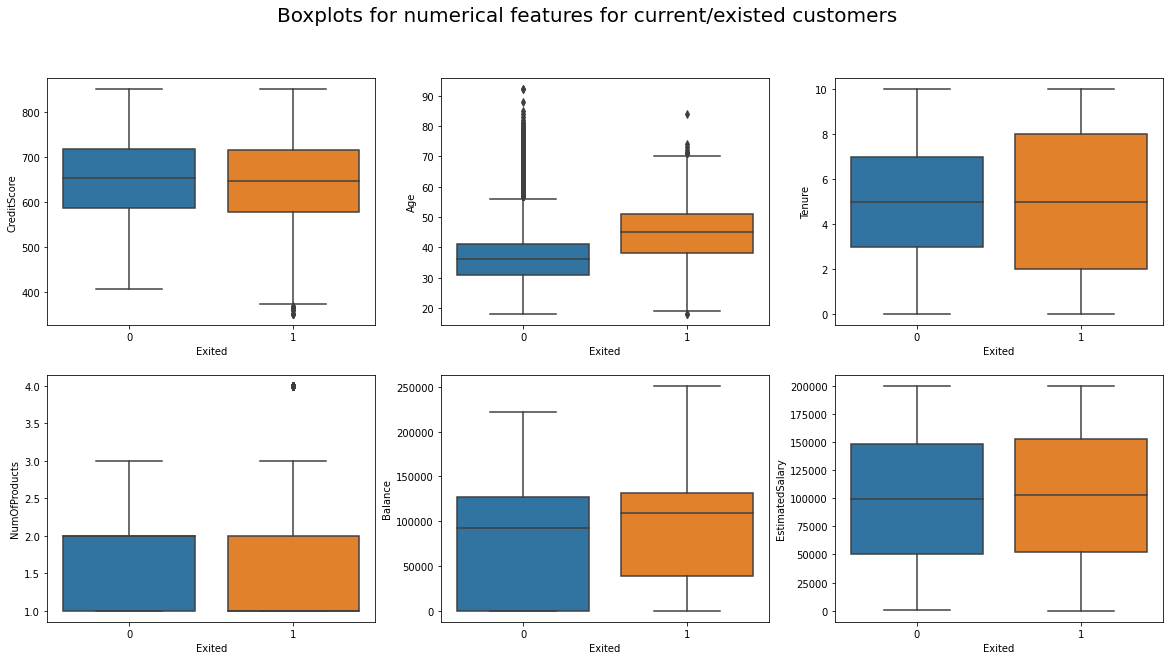

In [9]:
# boxplot for numerical features, in this part, we do the plots for churn and not churned clients separately.
fig,axss=plt.subplots(2,3,figsize=[20,10]) # from matplotlib.pyplot
sns.boxplot(x='Exited',y='CreditScore',data=churn_df,ax=axss[0][0])
sns.boxplot(x='Exited',y='Age',data=churn_df,ax=axss[0][1])
sns.boxplot(x='Exited',y='Tenure',data=churn_df,ax=axss[0][2])
sns.boxplot(x='Exited',y='NumOfProducts',data=churn_df,ax=axss[1][0])
sns.boxplot(x='Exited',y='Balance',data=churn_df,ax=axss[1][1])
sns.boxplot(x='Exited',y='EstimatedSalary',data=churn_df,ax=axss[1][2])

fig.suptitle("Boxplots for numerical features for current/existed customers",fontsize=20)

Most of the numerica features seem to be reasonable. 
There are two things I noticed:
1) Some variables have already shown the difference between current and churned cliens, such as age,tenure and balance. I will keep an eye on that for the furthur analysis.
2) there are a few outliers for the age-0 group. The total amount of outliers are 2.8% (see cell below). Currently I still think it makes sense from a business point and we should still keep these data. 

In [10]:
age_outlier=churn_df[(churn_df['Exited']==0 )&(churn_df['Age']>62)]
# 44+(44-32)*1.5=62
age_outlier.shape # 2.8% of the data

(286, 14)

In [11]:
# correlations between all numerical features
corr = churn_df[['CreditScore','Age','Tenure','NumOfProducts','Balance','EstimatedSalary']].corr()
corr.round(2)

,CreditScore,Age,Tenure,NumOfProducts,Balance,EstimatedSalary
CreditScore,1.00,-0.00,0.00,0.01,0.01,-0.00
Age,-0.00,1.00,-0.01,-0.03,0.03,-0.01
Tenure,0.00,-0.01,1.00,0.01,-0.01,0.01
NumOfProducts,0.01,-0.03,0.01,1.00,-0.30,0.01
Balance,0.01,0.03,-0.01,-0.30,1.00,0.01
EstimatedSalary,-0.00,-0.01,0.01,0.01,0.01,1.00


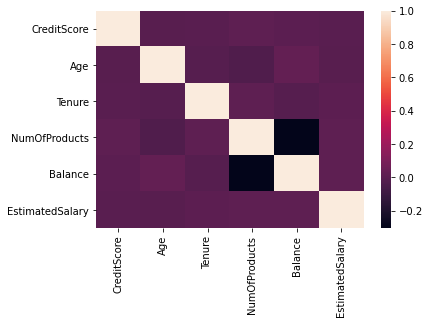

In [12]:
# show heapmap of correlations
sns.heatmap(corr)

here, only the correaltion between balance and NumofProduct stands out. Whether it matters will depend on what model I choose in the furthur analysis. If it is regression, then we probably need to either use regularization term/drop certain features to avoid multicolinnearity. However, if I choose tree models, such as Random Forest, then it does not matter.

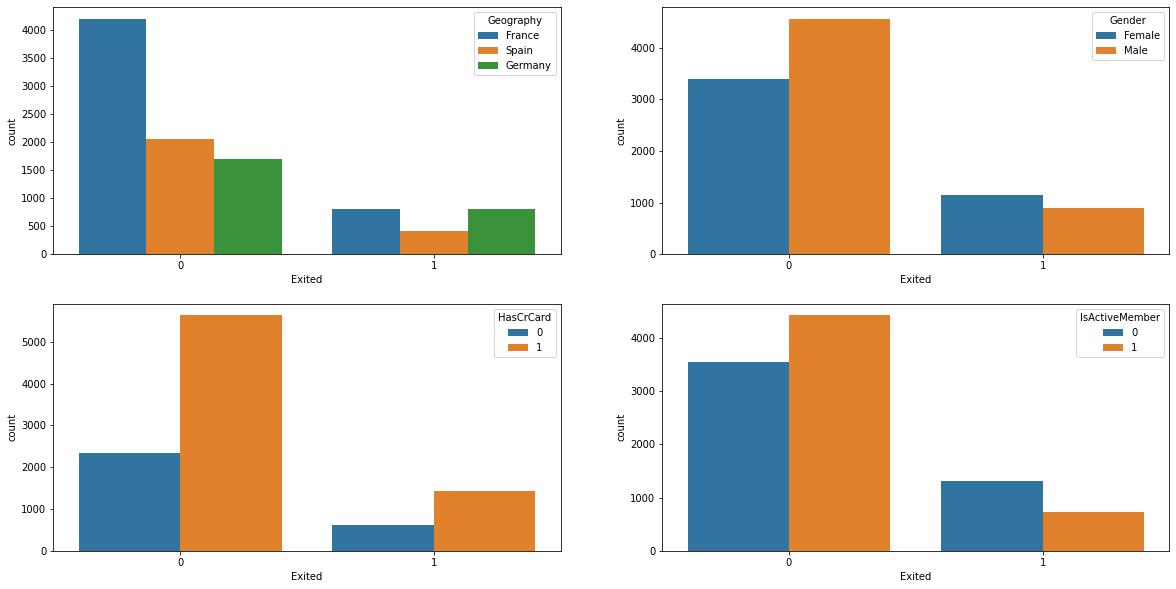

In [13]:
# undersatnd categorical features
figure,axss=plt.subplots(2,2,figsize=[20,10])
# hue -- levels to plot the levels in -- for cateogrical variables. similar to color= varaible in R
sns.countplot(x="Exited",hue='Geography',data=churn_df,ax=axss[0][0])
sns.countplot(x='Exited',hue='Gender',data=churn_df,ax=axss[0][1])
sns.countplot(x='Exited',hue='HasCrCard',data=churn_df,ax=axss[1][0])
sns.countplot(x='Exited',hue='IsActiveMember',data=churn_df,ax=axss[1][1])

I did plots this way but I will try to be very carefull if I want to present them to my clients.
First, the proportion of Exited==0 and Exited==1 is like 3:1. So it is easy for clients to focus too much on the height difference between 0 and 1, rather than focus on the patterns within gorup0 and group1.
Here, I can see that the pattern is similar for both groups regarding to the variable 'HasCrCard'. For the other categorical variables, group0 and group1 seem to have different patterns.

# Part 2: Feature Preprocessing

I found these following websites very useful:
https://github.com/scikit-learn-contrib/categorical-encoding

package for encoding:
https://contrib.scikit-learn.org/categorical-encoding/#category-encoders


### Part 2.1: Feature encoding 

In [14]:
# change binary to boolean
churn_df['Gender']=churn_df['Gender']=='Female'
# if it Female, then True, o.w. then False

# one hot encoding
# change polynomous data to a bunch of T/F 
churn_df=pd.get_dummies(churn_df,columns=["Geography"])

In [15]:
# make sure one hot encoding is working 
churn_df.head()

,RowNumber,CustomerId,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,True,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,2,15647311,Hill,608,True,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,True,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,4,15701354,Boni,699,True,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,5,15737888,Mitchell,850,True,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [16]:
# drop useless features
to_drop=['RowNumber','CustomerId','Surname','Exited']

# separte features and output
X=churn_df.drop(to_drop,axis=1)
y=churn_df['Exited']

### Part 2.1: Feature scaling 
This part belongs to data preprocessing .However, since wheather to scale the features also depends on what models we are planning to use. I decide to combine this part with the models in Part 3. 

The rule of thumb for scaling is : for the models that requires to compute distance or assumes normality, we should scale the features.
The common models we use that requires feature scaling are :
1) KNN -- Euclidean distance , sensistive to magnitudes
2) PCA -- get the features with maximum variance and the variance is hihg for high magnitude features. This skws the PCA towars high magnitude features
3) Gradient descent -- scaling can speed up the gradient desent procedure, because theta will descend quickly on small ranges and slowly on large ranges.


The ones usually do not require scaling:
1) Tree based models
2) Linear Discriminant Analysis (LDA) , Naive Bayes: by design, they will gives weights to the features accordingly, so no need to scale. 


Common Scaling: 
1) standardization
2) mean normalisation: (x-mean(x))/(max(x)-min(X))
-- 1) 2) zero centric : e.g. for PCA
3) min-max scaling :(x-min(x))/(max(x)-min(x))
4) unit vector x/||x||
-- 3) 4) provide values between [0,1] -usefull for handling data with hard boundaries, such as image date (colors code [0,255])

# Part 3: Model Training and Result Evaluation

### Part 3.1: Prepare the dataset for Machine Learning Models

In [57]:
# Split data into training and testing
from sklearn import model_selection

# Reserve 20% for testing, this just follows a common 80-20 rule.
# the porportion of testing can change depends on the actual project
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2,stratify=y)

print('training data has %d observation with %d features'% X_train.shape) 
print('test data has %d observation with %d features'% X_test.shape)

training data has 8000 observation with 12 features
test data has 2000 observation with 12 features


In [58]:
# Scale the data, using standardization
# https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py
# https://scikit-learn.org/stable/modules/preprocessing.html

from sklearn.preprocessing import StandardScaler
# training data--we did the fit transform, based on its mean and sd
scalar=StandardScaler() # get the mean/sd from X_train
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

# max-min training is scalar=MinMaxScaler()

### Part 3.2: Model Training and Selection

In [24]:
#@title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()
# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier()
# Random Forest
classifier_RF = RandomForestClassifier()

Run each ML model once to get the intuition

In [59]:
## LR
# Train the model
classifier_logistic.fit(X_train_scaled, y_train)
# Accuracy of test data
print("The Accuracy of logistic Regression Model is %f"%classifier_logistic.score(X_test, y_test))

# KNN
# Train the model
classifier_KNN.fit(X_train_scaled, y_train)
# Accuracy of test data
print("The Accuracy of KNN is %f"%classifier_KNN.score(X_test, y_test))


# RF
# Train the model
classifier_RF.fit(X_train, y_train)
# Accuracy of test data
print("The Accuracy of Random Forest Model is %f"%classifier_RF.score(X_test, y_test))

The Accuracy of logistic Regression Model is 0.203500
The Accuracy of KNN is 0.479500
The Accuracy of Random Forest Model is 0.862000


### Part 3.3: Use Grid Search to Find Optimal Hyperparameters

Here the scoring method is recall, since recall is the criterion of interset.

In [26]:
# hyperparameters in RF
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %s" % (param_name, best_parameters[param_name]))
# %s -- string, %r -- useful for printing a string of unknown encoding

#### Part 3.3.1: Find Optimal Hyperparameters - LogisticRegression

even though we are interested in recall, when training the model, it is tricky.
for recall , TP/(TP+FN), in extreme cases that we consider all participants are churned, then the recall=100%. However, the accuracy will get lower to like 20% . Because in the raw data, 20% of the customered exited the program.

On the other hand, accuracy is not a very good measure either, sicne our data is imbalanced. So if we just use accruacy, then in the extreme cases, if we speciify all our clients as not churend, then we still get 80% accuracy.

In this case, I will choose AUC as our evaluation criterion (not to overfit a single class). 

In [64]:
# Possible hyperparamter options for Logistic Regression Regularization
# l1,l2 norm
# C: 1/lambda 
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}

Grid_LR = GridSearchCV(LogisticRegression(solver='liblinear'),parameters, cv=5, scoring = 'roc_auc')
Grid_LR.fit(X_train_scaled, y_train)

# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

Best score: 0.762
Best parameters set:
	C: 1
	penalty: l1


In [61]:
# save the best model parameters 
best_LR_model = Grid_LR.best_estimator_

#### Part 3.3.2: Find Optimal Hyperparameters: KNN

In [65]:
# Choose number of neighbors
parameters = {
    'n_neighbors':[3,5,7,10] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=5, scoring = 'roc_auc')
Grid_KNN.fit(X_train_scaled, y_train)

# best k
print_grid_search_metrics(Grid_KNN)

Best score: 0.797
Best parameters set:
	n_neighbors: 10


In [66]:
# save the best model paraemters
best_KNN_model=Grid_KNN.best_estimator_

#### Part 3.3.3: Find Optimal Hyperparameters: Random Forest

In [67]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [20,40,60,80]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=5, scoring = 'roc_auc')
Grid_RF.fit(X_train, y_train)

# best number of tress
print_grid_search_metrics(Grid_RF)

Best score: 0.856
Best parameters set:
	n_estimators: 80


In [68]:
# best random forest
best_RF_model = Grid_RF.best_estimator_

### Part 3.4: Model Evaluation using Confusion Matrix (Precision, Recall, Accuracy)

exited:1 (churn) 0 (not churn)

TP: correctly labeled real churn

Precision(PPV, positive predictive value): tp / (tp + fp);
Total number of true predictive churn divided by the total number of predictive churn;
High Precision means low fp, not many return users were predicted as churn users. 

Recall(sensitivity, hit rate, true positive rate): tp / (tp + fn)
Predict most postive or churn user correctly. High recall means low fn, not many churn users were predicted as return users.

In this situation, recall is more important than precision

In [69]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall) # the criterion we are interested in 

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['Not','Churn']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

Logistic Regression
Accuracy is: 0.808
precision is: 0.588
recall is: 0.197


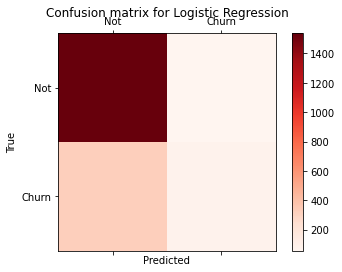

K Nearest Neighbour
Accuracy is: 0.715
precision is: 0.269
recall is: 0.233


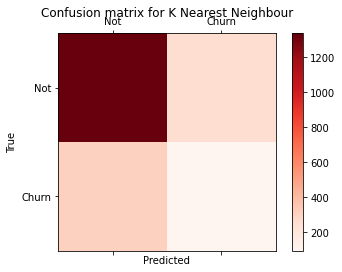

Random Forest
Accuracy is: 0.863
precision is: 0.767
recall is: 0.469


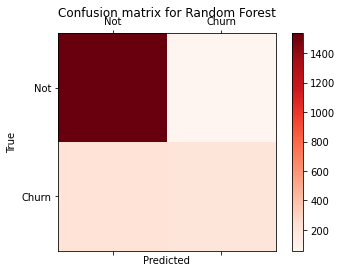

In [70]:
# the sequence: true value first， and the prediction
# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(X_test))),
    ("K Nearest Neighbour", confusion_matrix(y_test,best_KNN_model.predict(X_test))),
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(X_test)))
]

draw_confusion_matrices(confusion_matrices)

### Part 3.4: Model Evaluation - ROC & AUC

#### Part 3.4.1: ROC of RF Model

In [71]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)

In [72]:
best_RF_model.predict_proba(X_test) # predict class probability

array([[0.9   , 0.1   ],
       [0.825 , 0.175 ],
       [0.9875, 0.0125],
       ...,
       [0.8375, 0.1625],
       [0.825 , 0.175 ],
       [0.7125, 0.2875]])

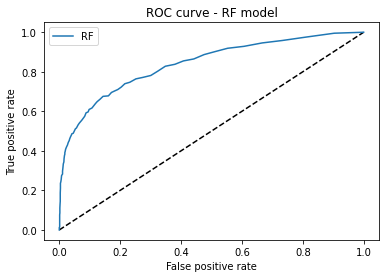

In [73]:
# ROC curve of Random Forest result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF model')
plt.legend(loc='best')
plt.show()

In [74]:
from sklearn import metrics

# AUC score -- area under curve
metrics.auc(fpr_rf,tpr_rf)

0.839341652900975

#### Part 3.4.1: ROC of LR Model

In [75]:
# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(X_test_scaled)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)

In [76]:
best_LR_model.predict_proba(X_test_scaled)

array([[0.82336016, 0.17663984],
       [0.93031261, 0.06968739],
       [0.70040958, 0.29959042],
       ...,
       [0.9575283 , 0.0424717 ],
       [0.85316473, 0.14683527],
       [0.93526272, 0.06473728]])

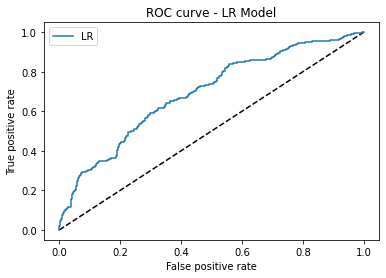

In [77]:
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

In [78]:
# AUC score
metrics.auc(fpr_lr,tpr_lr)

0.6915790983587593

# Part 4: Feature Selection

### Part 4.1:  Logistic Regression Model - Feature Selection Discussion 

The correlated features that we are interested in:

In [79]:
import numpy as np

X_with_corr=X.copy()
X_with_corr['SalaryInRMB']=X['EstimatedSalary']*6.94

In [80]:
# add L1 regularization to logistic regression
# check the coef for feature selection
# L1-LASSO L2-RIDGE
scaler = StandardScaler()
X_l1 = scaler.fit_transform(X_with_corr)
LRmodel_l1 = LogisticRegression(penalty="l1", C = 0.1,solver="liblinear") # if default solver lbfgs only suppports L2 or none  
# see document :https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
LRmodel_l1.fit(X_l1, y)

indices=np.argsort(abs(LRmodel_l1.coef_[0]))[::-1] # sort by value from largest to smallest, the return values are the index 

print ("Logistic Regression (L1) Coefficients")
for ind in indices:
    print ("{0}: {1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l1.coef_[0][indices[ind]],4)))

Logistic Regression (L1) Coefficients
Geography_Germany: 0.3171
Tenure: -0.0384
Geography_France: -0.0123
IsActiveMember: -0.524
Balance: 0.159
Age: 0.7495
CreditScore: -0.0569
Gender: 0.2541
EstimatedSalary: 0.0201
NumOfProducts: -0.0529
HasCrCard: -0.013
Geography_Spain: 0.0
SalaryInRMB: 0.0


In [82]:
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_with_corr)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1,solver='liblinear')
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]

array([-0.06367794,  0.25913053,  0.75099022, -0.04520424,  0.16199493,
       -0.0585934 , -0.01993898, -0.52716425,  0.01367085, -0.12070832,
        0.22788348, -0.08904964,  0.01367085])

In [83]:
# add L2 regularization to logistic regression
# check the coef for feature selection
scaler = StandardScaler()
X_l2 = scaler.fit_transform(X_with_corr)
LRmodel_l2 = LogisticRegression(penalty="l2", C = 0.1,solver='liblinear')
LRmodel_l2.fit(X_l2, y)
LRmodel_l2.coef_[0]

indices = np.argsort(abs(LRmodel_l2.coef_[0]))[::-1]

print ("Logistic Regression (L2) Coefficients")
for ind in indices:
    print ("{0}:{1}".format(X_with_corr.columns[indices[ind]],round(LRmodel_l2.coef_[0][indices[ind]],4)))
  

Logistic Regression (L2) Coefficients
Gender:0.2591
CreditScore:-0.0637
IsActiveMember:-0.5272
HasCrCard:-0.0199
Balance:0.162
Tenure:-0.0452
EstimatedSalary:0.0137
Age:0.751
Geography_France:-0.1207
Geography_Germany:0.2279
Geography_Spain:-0.089
NumOfProducts:-0.0586
SalaryInRMB:0.0137


### Part 4.2:  Random Forest Model - Feature Importance Discussion

In [84]:
# check feature importance of random forest for feature selection
forest = RandomForestClassifier()
forest.fit(X, y)

importances = forest.feature_importances_

indices=np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for ind in range(X.shape[1]):
    print ("{0}:{1}".format(X.columns[indices[ind]],round(importances[indices[ind]],4)))

Feature importance ranking by Random Forest Model:
Age:0.2424
EstimatedSalary:0.1478
CreditScore:0.1445
Balance:0.1427
NumOfProducts:0.1285
Tenure:0.0808
IsActiveMember:0.0385
Geography_Germany:0.0206
HasCrCard:0.0178
Gender:0.0176
Geography_France:0.0101
Geography_Spain:0.0089


The previous results show that age is the main feature that affects customers' churn. 

If we go back to the boxplot, we noticed that the people averaged over 45 years old has more tendancy to churn comparing to the younger group. 